### data load

In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import BertTokenizer
from data_utils import get_examples_from_dialogues, convert_state_dict, load_dataset
from data_utils import OntologyDSTFeature, DSTPreprocessor, _truncate_seq_pair

### matplotlib 한글 설정

In [14]:
# 설치 후 런타임 다시 시작(코랩의 경우)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# plt.rc('font', family='NanumBarunGothic')

In [3]:
train_dials = json.load(open('../../input/data/train_dataset/train_dials.json'))
slot_meta = json.load(open('../../input/data/train_dataset/slot_meta.json'))
ontology = json.load(open('../../input/data/train_dataset/ontology.json'))

eval_dials = json.load(open('../../input/data/eval_dataset/eval_dials.json'))
eval_meta = json.load(open('../../input/data/eval_dataset/slot_meta.json'))

### train_dials

In [4]:
print("len_train_dials:", len(train_dials))
print("train_dials[0].keys(): ", train_dials[0].keys())

len_train_dials: 7000
train_dials[0].keys():  dict_keys(['dialogue_idx', 'domains', 'dialogue'])


### slot_meta

In [5]:
print(type(slot_meta))
slot_meta[:5]

<class 'list'>


['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-역사적']

### ontology

In [6]:
print(type(ontology))
print(len(ontology))
ontology.keys()

<class 'dict'>
45


dict_keys(['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-역사적', '관광-이름', '관광-종류', '관광-주차 가능', '관광-지역', '숙소-가격대', '숙소-도보 가능', '숙소-수영장 유무', '숙소-스파 유무', '숙소-예약 기간', '숙소-예약 명수', '숙소-예약 요일', '숙소-이름', '숙소-인터넷 가능', '숙소-조식 가능', '숙소-종류', '숙소-주차 가능', '숙소-지역', '숙소-헬스장 유무', '숙소-흡연 가능', '식당-가격대', '식당-도보 가능', '식당-야외석 유무', '식당-예약 명수', '식당-예약 시간', '식당-예약 요일', '식당-이름', '식당-인터넷 가능', '식당-종류', '식당-주류 판매', '식당-주차 가능', '식당-지역', '식당-흡연 가능', '지하철-도착지', '지하철-출발 시간', '지하철-출발지', '택시-도착 시간', '택시-도착지', '택시-종류', '택시-출발 시간', '택시-출발지'])

###  WoS의 Domain은 몇개이며, 어떤 Domain으로 이루어져있는지 확인해봅니다

In [31]:
domains = set([slot.split('-')[0] for slot in slot_meta])
print("Domain 갯수: ", len(domains))
print("Domain 종류: ", domains)

Domain 갯수:  5
Domain 종류:  {'관광', '택시', '지하철', '식당', '숙소'}


### WoS의 Slot은 몇개이며, Domain별로 어떤 Slot으로 이루어져있는지 확인해봅니다.

In [75]:
print("slot 갯수: ", len(slot_meta))
slot_by_domain ={}
for domain in domains:
    slot_by_domain[domain] = []
    for meta in slot_meta:
        slot = meta.split('-')
        if slot[0] == domain:
            slot_by_domain[domain].append(slot[1])

print("Domain별 slot type")
for domain in slot_by_domain.keys():
    print(f'{domain} slot 갯수: {len(slot_by_domain[domain])}')
    print(f'{domain}: {slot_by_domain[domain]}')
    print()

    

slot 갯수:  45
Domain별 slot type
관광 slot 갯수: 9
관광: ['경치 좋은', '교육적', '도보 가능', '문화 예술', '역사적', '이름', '종류', '주차 가능', '지역']

택시 slot 갯수: 5
택시: ['도착 시간', '도착지', '종류', '출발 시간', '출발지']

지하철 slot 갯수: 3
지하철: ['도착지', '출발 시간', '출발지']

식당 slot 갯수: 13
식당: ['가격대', '도보 가능', '야외석 유무', '예약 명수', '예약 시간', '예약 요일', '이름', '인터넷 가능', '종류', '주류 판매', '주차 가능', '지역', '흡연 가능']

숙소 slot 갯수: 15
숙소: ['가격대', '도보 가능', '수영장 유무', '스파 유무', '예약 기간', '예약 명수', '예약 요일', '이름', '인터넷 가능', '조식 가능', '종류', '주차 가능', '지역', '헬스장 유무', '흡연 가능']



### WoS의 Value은 몇개이며, Slot당 Value가 어떻게 이루어져있는지 확인해봅니다.

In [105]:
train_dials[0]
value_by_slot_and_domain ={}
total_value_set = set()

for domain in domains:
    value_by_slot_and_domain[domain] = {}
    for meta in slot_meta:
        slot = meta.split('-')
        if slot[0] == domain:
            value_by_slot_and_domain[domain][slot[1]] = set()


for e in train_dials:
    dialogue = e['dialogue']
    for d in dialogue:
        if len(d) > 2:  # state가 없는 turn 예외 처리
            values = d['state']
            for value in values:
                domain, slot, value = value.split('-')
                value_by_slot_and_domain[domain][slot].add(value)
                total_value_set.add(value)
print(value_by_slot_and_domain['관광'])


{'경치 좋은': {'yes'}, '교육적': {'yes'}, '도보 가능': {'yes'}, '문화 예술': {'yes'}, '역사적': {'no', 'yes', 'dontcare'}, '이름': {'여의도 공원', '낙산공원', '정동극장', '남산골 한옥 마을', '스타필드 코엑스몰', '봉은사', '국립 고궁 박물관', '서초관광정보센터', '국립 민속 박물관', '별마당 도서관', '올림픽 공원', '이화여자대학교', '남대문시장', '박물관은살아있다 인사동점', '하늘공원', '삼청동길', '롯데월드타워&몰', '조계사', '동대문 디자인 플라자', '여의도 한강공원', '인왕산', '남산 공원', '동대문 (흥인지문)', '서울 월드컵 경기장 (상암 월드컵 경기장)', '선릉과 정릉', '신세계 백화점 본점', '한국 전쟁 기념관', '중부시장', '디큐브시브', '창경궁', '삼성미술관 리움', '광화문 광장', '동대문 역사 문화 공원', '대한민국 역사 박물관', '가로수길', '서울중앙성원', '서울숲', '국립국악원', '이태원', '숭례문', '동대문 쇼핑몰', '운현궁', '삼청각', '낙산 공공 미술', '이대 패션거리', '익선동한옥거리', '북악산 서울 성곽', '충무공 이순신 동상', '명동 쇼핑 거리', '고투 몰', '창덕궁', '서울로7017', '광화문', '청와대', '잠실 야구 경기장', '이화 벽화마을', '청계천', '종묘', '서울 한양 도성', '예술의전당', '국립중앙박물관', '롯데월드 아쿠아리움', '경복궁', '국립현대미술관 서울관', '북한산 국립공원', 'IFC 몰', '서울스카이', '마장 축산물시장', '신촌', '서울 어린이 대공원', '한국의 집', '코엑스 센터', '서울 대학로', '명동 성당', '러브뮤지엄', '서울 시청', '남산 케이블카', '63시티', '타임스퀘어', '롯데백화점 본점', '명동난타극장', '문화역서울 284', '인사동', '광장시장', '석촌호수', '코엑스 

In [106]:
print("Domain별 slot type별 values")
print('전체 value 갯수: ', len(total_value_set))
for domain in value_by_slot_and_domain.keys():
    print(f'{domain} slot 갯수: {len(slot_by_domain[domain])}')
    print(f'{domain}: {slot_by_domain[domain]}')
    print()
    for slot in value_by_slot_and_domain[domain]:
        print(f'{slot} value 갯수: {len(value_by_slot_and_domain[domain][slot])}')
        print(f'{slot}: {value_by_slot_and_domain[domain][slot]}')
        print()
    print()



Domain별 slot type별 values
전체 value 갯수:  1113
관광 slot 갯수: 9
관광: ['경치 좋은', '교육적', '도보 가능', '문화 예술', '역사적', '이름', '종류', '주차 가능', '지역']

경치 좋은 value 갯수: 1
경치 좋은: {'yes'}

교육적 value 갯수: 1
교육적: {'yes'}

도보 가능 value 갯수: 1
도보 가능: {'yes'}

문화 예술 value 갯수: 1
문화 예술: {'yes'}

역사적 value 갯수: 3
역사적: {'no', 'yes', 'dontcare'}

이름 value 갯수: 101
이름: {'여의도 공원', '낙산공원', '정동극장', '남산골 한옥 마을', '스타필드 코엑스몰', '봉은사', '국립 고궁 박물관', '서초관광정보센터', '국립 민속 박물관', '별마당 도서관', '올림픽 공원', '이화여자대학교', '남대문시장', '박물관은살아있다 인사동점', '하늘공원', '삼청동길', '롯데월드타워&몰', '조계사', '동대문 디자인 플라자', '여의도 한강공원', '인왕산', '남산 공원', '동대문 (흥인지문)', '서울 월드컵 경기장 (상암 월드컵 경기장)', '선릉과 정릉', '신세계 백화점 본점', '한국 전쟁 기념관', '중부시장', '디큐브시브', '창경궁', '삼성미술관 리움', '광화문 광장', '동대문 역사 문화 공원', '대한민국 역사 박물관', '가로수길', '서울중앙성원', '서울숲', '국립국악원', '이태원', '숭례문', '동대문 쇼핑몰', '운현궁', '삼청각', '낙산 공공 미술', '이대 패션거리', '익선동한옥거리', '북악산 서울 성곽', '충무공 이순신 동상', '명동 쇼핑 거리', '고투 몰', '창덕궁', '서울로7017', '광화문', '청와대', '잠실 야구 경기장', '이화 벽화마을', '청계천', '종묘', '서울 한양 도성', '예술의전당', '국립중앙박물관', '롯데월드 아쿠아리움', '경복궁', '

### Domain별로 자주 사용되는 Bigram과 Trigram은 어떤것인지 확인해봅니다.

In [123]:
from collections import Counter

def n_gram(word, n=2):
    arr = []
    for i in range(len(word) - (n-1)):  # 2-gram이므로 문자열의 끝에서 한 글자 앞까지만 반복함
        arr.append(word[i:i+n])
    return arr

- 관광

In [125]:
for domain in value_by_slot_and_domain.keys():

    current_domain = value_by_slot_and_domain[domain]
    bigram_list = []
    trigram_list = []
    for slot_type in current_domain.keys():
        for value in current_domain[slot_type]:
            bigram_list.extend(n_gram(value, 2))
            trigram_list.extend(n_gram(value, 3))
    
    print(f'{domain} bigram 최빈수: ', Counter(bigram_list).most_common()[:5])
    print(f'{domain} trigram 최빈수: ', Counter(trigram_list).most_common()[:5])
    print()

관광 bigram 최빈수:  [('서울', 22), ('울 ', 14), ('공원', 12), ('박물', 7), ('물관', 7)]
관광 trigram 최빈수:  [('서울 ', 14), ('박물관', 7), ('yes', 6), (' 공원', 5), ('대문 ', 5)]

택시 bigram 최빈수:  [(':1', 129), (':4', 125), (':0', 97), ('1:', 94), (':2', 93)]
택시 trigram 최빈수:  [(':30', 49), (':00', 47), (':50', 45), (':15', 45), (':40', 44)]

지하철 bigram 최빈수:  [('문역', 10), ('입구', 8), ('구역', 8), ('원역', 8), ('대입', 6)]
지하철 trigram 최빈수:  [('입구역', 8), ('대입구', 6), ('대문역', 6), ('12:', 6), ('사당역', 4)]

식당 bigram 최빈수:  [(':4', 106), (':5', 105), (':1', 101), (':2', 88), (':0', 87)]
식당 trigram 최빈수:  [('17:', 32), ('16:', 31), ('18:', 30), ('19:', 30), ('12:', 29)]

숙소 bigram 최빈수:  [(' 호', 22), ('호텔', 20), ('서울', 15), (' 서', 10), ('do', 9)]
숙소 trigram 최빈수:  [(' 호텔', 17), ('don', 9), ('ont', 9), ('ntc', 9), ('tca', 9)]



### max_turn_length

In [12]:
max([len(dial['dialogue']) for dial in train_dials])

34

### 예측 틀린(miss gold) slot value 분석

In [3]:
miss_label_dict = json.load(open('eda_data/TRADE_gate5_batch16_epoch30_notranspose_miss_labels.json'))

In [97]:
# miss_label_dict

In [4]:
print(miss_label_dict.keys())
print([len(v) for i, v in miss_label_dict.items()])

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29'])
[2730, 2301, 2177, 2112, 2080, 1971, 1912, 1877, 1856, 1785, 1801, 1694, 1673, 1589, 1540, 1499, 1447, 1408, 1391, 1344, 1314, 1272, 1237, 1222, 1218, 1187, 1171, 1159, 1142, 1139]


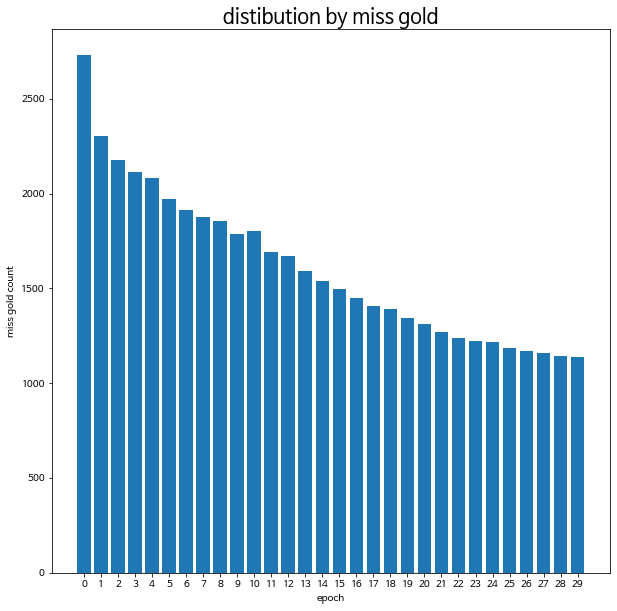

In [175]:
# 시각화
plt.figure(figsize=(10, 10))  # size설정
xtick_label_position = list(range(len(list(miss_label_dict.keys()))))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, list(miss_label_dict.keys()))  # x축 눈금 라벨 출력

plt.bar(xtick_label_position, [len(v) for i, v in miss_label_dict.items()])  # 바차트 출력

plt.title('distibution by miss gold', fontsize=20)  # 타이틀 출력
plt.xlabel('epoch')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

### 도메인별 오측 갯수

In [5]:
from collections import Counter

In [8]:
def create_count_list(epoch: int):
    slot_list = [e['slot'].split('-')[0] for e in miss_label_dict[str(epoch)]]

    count_list = Counter(slot_list).items()
    return sorted(count_list)

count_list5 = create_count_list(5)

count_list15 = create_count_list(14)

count_list29 = create_count_list(29)

count_list29

[('관광', 257), ('숙소', 258), ('식당', 471), ('지하철', 16), ('택시', 137)]

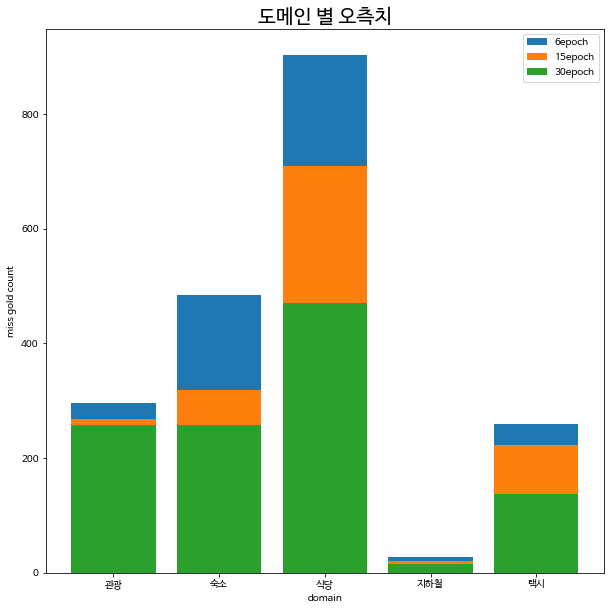

In [9]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(10,10))  # size설정
ax = fig.add_subplot(111)
xtick_label_position = list(range(len(count_list29)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in count_list29])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in count_list5], label='6epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in count_list15], label='15epoch')
ax.bar(xtick_label_position, [e[1] for e in count_list29], label='30epoch')  # 바차트 출력
ax.legend()

plt.title('도메인 별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

## 도메인별 오측치

### 관광 slot별 오측치

In [33]:
from typing import List

def create_count_list_by_domain(epoch: int, domain: str):
    slot_list = [e['slot'].split('-')[1] for e in miss_label_dict[str(epoch)] if e['slot'].split('-')[0] == domain]

    count_list = Counter(slot_list).items()
    return sorted(count_list)

def filter_rare_case(list: List[tuple], k: int):
    return [e for e in list if e[1] > k]

In [14]:
tour_list7 = create_count_list_by_domain(6, '관광')
tour_list15 = create_count_list_by_domain(14, '관광')
tour_list30 = create_count_list_by_domain(29, '관광')

tour_list7

[('이름', 146), ('종류', 62), ('지역', 85)]

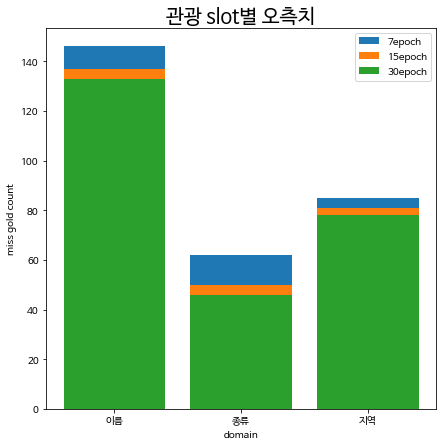

In [15]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(7, 7))  # size설정
ax = fig.add_subplot(111)
xtick_label_position = list(range(len(tour_list7)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in tour_list7])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in tour_list7], label='7epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in tour_list15], label='15epoch')
ax.bar(xtick_label_position, [e[1] for e in tour_list30], label='30epoch')
ax.legend()

plt.title('관광 slot별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

### 숙소 slot별 오측치

In [69]:
lodgment_list7 = create_count_list_by_domain(7, '숙소')
lodgment_list15 = create_count_list_by_domain(15, '숙소')
lodgment_list30 = create_count_list_by_domain(29, '숙소')
filtered_lodgment_list7 = filter_rare_case(lodgment_list7, 2)
filtered_lodgment_list15 = filter_rare_case(lodgment_list15, 2)
filtered_lodgment_list30 = filter_rare_case(lodgment_list30, 2)
print(filtered_lodgment_list7)
print(filtered_lodgment_list15)
print(filtered_lodgment_list30)

[('가격대', 73), ('예약 기간', 81), ('예약 명수', 71), ('예약 요일', 54), ('이름', 67), ('종류', 29), ('주차 가능', 8), ('지역', 58)]
[('가격대', 48), ('예약 기간', 30), ('예약 명수', 40), ('예약 요일', 42), ('이름', 46), ('종류', 18), ('주차 가능', 16), ('지역', 57)]
[('가격대', 39), ('예약 기간', 6), ('예약 명수', 36), ('예약 요일', 47), ('이름', 46), ('종류', 27), ('주차 가능', 8), ('지역', 48)]


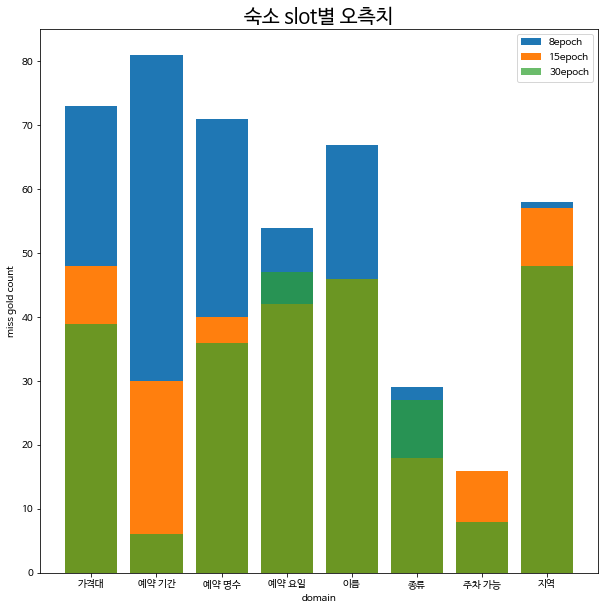

In [66]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(10,10))  # size설정
ax = fig.add_subplot(111)

xtick_label_position = list(range(len(filtered_lodgment_list7)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in filtered_lodgment_list7])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in filtered_lodgment_list7], label='8epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in filtered_lodgment_list15], label='15epoch')
ax.bar(xtick_label_position, [e[1] for e in filtered_lodgment_list30], label='30epoch', alpha=0.7)




ax.legend()

plt.title('숙소 slot별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

### 식당 slot별 오측치

In [75]:
restaurant_list7 = create_count_list_by_domain(7, '식당')
restaurant_list15 = create_count_list_by_domain(15, '식당')
restaurant_list30 = create_count_list_by_domain(29, '식당')
filtered_restaurant_list7 = filter_rare_case(restaurant_list7, 2)
filtered_restaurant_list15 = filter_rare_case(restaurant_list15, 2)
filtered_restaurant_list30 = filter_rare_case(restaurant_list30, 2)
print(filtered_restaurant_list7)
print(filtered_restaurant_list15)
print(filtered_restaurant_list30)

[('가격대', 30), ('예약 명수', 36), ('예약 시간', 623), ('예약 요일', 23), ('이름', 54), ('종류', 22), ('지역', 55), ('흡연 가능', 10)]
[('가격대', 18), ('예약 명수', 17), ('예약 시간', 443), ('예약 요일', 24), ('이름', 92), ('종류', 21), ('지역', 64), ('흡연 가능', 8)]
[('가격대', 10), ('예약 명수', 10), ('예약 시간', 239), ('예약 요일', 22), ('이름', 102), ('종류', 20), ('지역', 60), ('흡연 가능', 8)]


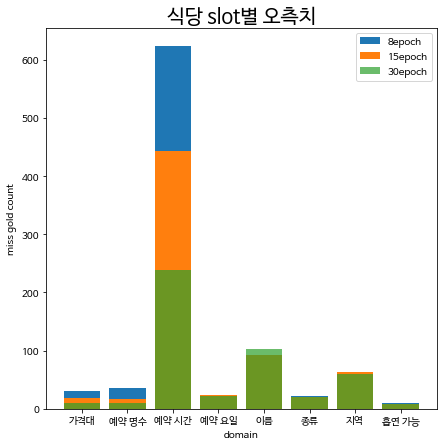

In [76]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(7,7))  # size설정
ax = fig.add_subplot(111)

xtick_label_position = list(range(len(filtered_restaurant_list7)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in filtered_restaurant_list7])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in filtered_restaurant_list7], label='8epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in filtered_restaurant_list15], label='15epoch')
ax.bar(xtick_label_position, [e[1] for e in filtered_restaurant_list30], label='30epoch', alpha=0.7)




ax.legend()

plt.title('식당 slot별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

### 지하철 slot별 오측치

In [84]:
subway_list7 = create_count_list_by_domain(7, '지하철')
subway_list15 = create_count_list_by_domain(15, '지하철')
subway_list30 = create_count_list_by_domain(29, '지하철')
filtered_subway_list7 = filter_rare_case(subway_list7, 2)
filtered_subway_list15 = filter_rare_case(subway_list15, 2)
filtered_subway_list30 = filter_rare_case(subway_list30, 2)

print(filtered_subway_list7)
print(filtered_subway_list15)
print(filtered_subway_list30)

filtered_subway_list30.append(('도착지', 0))
filtered_subway_list30.sort()
print(filtered_subway_list30)

[('도착지', 3), ('출발지', 18)]
[('도착지', 5), ('출발지', 13)]
[('출발지', 14)]
[('도착지', 0), ('출발지', 14)]


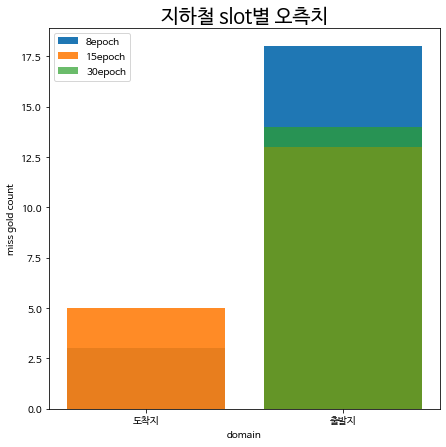

In [95]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(7,7))  # size설정
ax = fig.add_subplot(111)

xtick_label_position = list(range(len(filtered_subway_list7)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in filtered_subway_list7])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in filtered_subway_list7], label='8epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in filtered_subway_list15], label='15epoch', alpha=0.9)
ax.bar(xtick_label_position, [e[1] for e in filtered_subway_list30], label='30epoch', alpha=0.7)




ax.legend()

plt.title('지하철 slot별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()

### 택시 slot별 오측치

In [91]:
taxi_list7 = create_count_list_by_domain(7, '택시')
taxi_list15 = create_count_list_by_domain(15, '택시')
taxi_list30 = create_count_list_by_domain(29, '택시')
filtered_taxi_list7 = filter_rare_case(taxi_list7, 2)
filtered_taxi_list15 = filter_rare_case(taxi_list15, 2)
filtered_taxi_list30 = filter_rare_case(taxi_list30, 2)

print(filtered_taxi_list7)
print(filtered_taxi_list15)
print(filtered_taxi_list30)

filtered_taxi_list7.append(('종류', 0))
filtered_taxi_list15.append(('종류', 0))
filtered_taxi_list7.sort()
filtered_taxi_list15.sort()

print(filtered_taxi_list7)
print(filtered_taxi_list15)
print(filtered_taxi_list30)

[('도착 시간', 41), ('도착지', 21), ('출발 시간', 150), ('출발지', 44)]
[('도착 시간', 39), ('도착지', 16), ('출발 시간', 132), ('출발지', 35)]
[('도착 시간', 17), ('도착지', 20), ('종류', 6), ('출발 시간', 54), ('출발지', 40)]
[('도착 시간', 41), ('도착지', 21), ('종류', 0), ('출발 시간', 150), ('출발지', 44)]
[('도착 시간', 39), ('도착지', 16), ('종류', 0), ('출발 시간', 132), ('출발지', 35)]
[('도착 시간', 17), ('도착지', 20), ('종류', 6), ('출발 시간', 54), ('출발지', 40)]


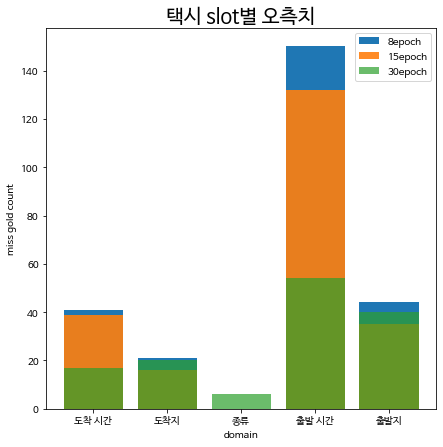

In [94]:
plt.rc('font', family='NanumBarunGothic')

fig = plt.figure(figsize=(7,7))  # size설정
ax = fig.add_subplot(111)

xtick_label_position = list(range(len(filtered_taxi_list7)))  # x축 눈금 라벨이 표시될 x좌표
plt.xticks(xtick_label_position, [e[0] for e in filtered_taxi_list7])  # x축 눈금 라벨 출력

ax.bar(xtick_label_position, [e[1] for e in filtered_taxi_list7], label='8epoch')  # 바차트 출력
ax.bar(xtick_label_position, [e[1] for e in filtered_taxi_list15], label='15epoch', alpha=0.9)
ax.bar(xtick_label_position, [e[1] for e in filtered_taxi_list30], label='30epoch', alpha=0.7)




ax.legend()

plt.title('택시 slot별 오측치', fontsize=20)  # 타이틀 출력
plt.xlabel('domain')  # x축 라벨 출력
plt.ylabel('miss gold count')  # y축 라벨 출력
plt.show()